In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import mglearn
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=22)

scaler = MinMaxScaler().fit(X_train)

In [3]:
X_train_scaled = scaler.transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.96


# Parameter Selection with Preprocessing

In [4]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요. 문제가 있음.

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.99
테스트 점수: 0.94
최적의 매개변수:  {'C': 10, 'gamma': 1}


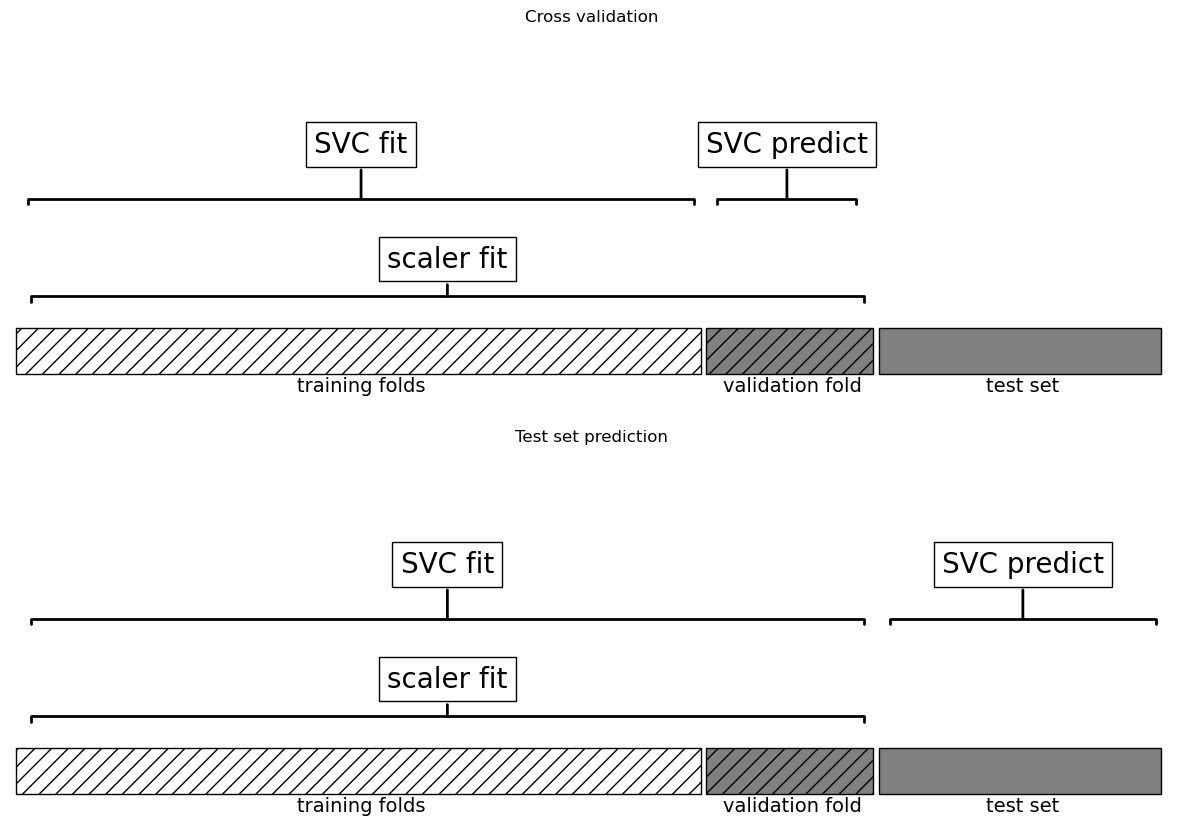

In [5]:
mglearn.plots.plot_improper_processing()

# Building Pipelines

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())]) 

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [8]:
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.96


# Using Pipelines in Grid Searches

In [9]:
param_grid = {'svm__C':[0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma':[0.001,0.01,0.1,1,10,100]}

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적의 매개변수:', grid.best_params_)

최상의 교차 검증 정확도: 0.99
테스트 세트 점수: 0.94
최적의 매개변수: {'svm__C': 10, 'svm__gamma': 1}


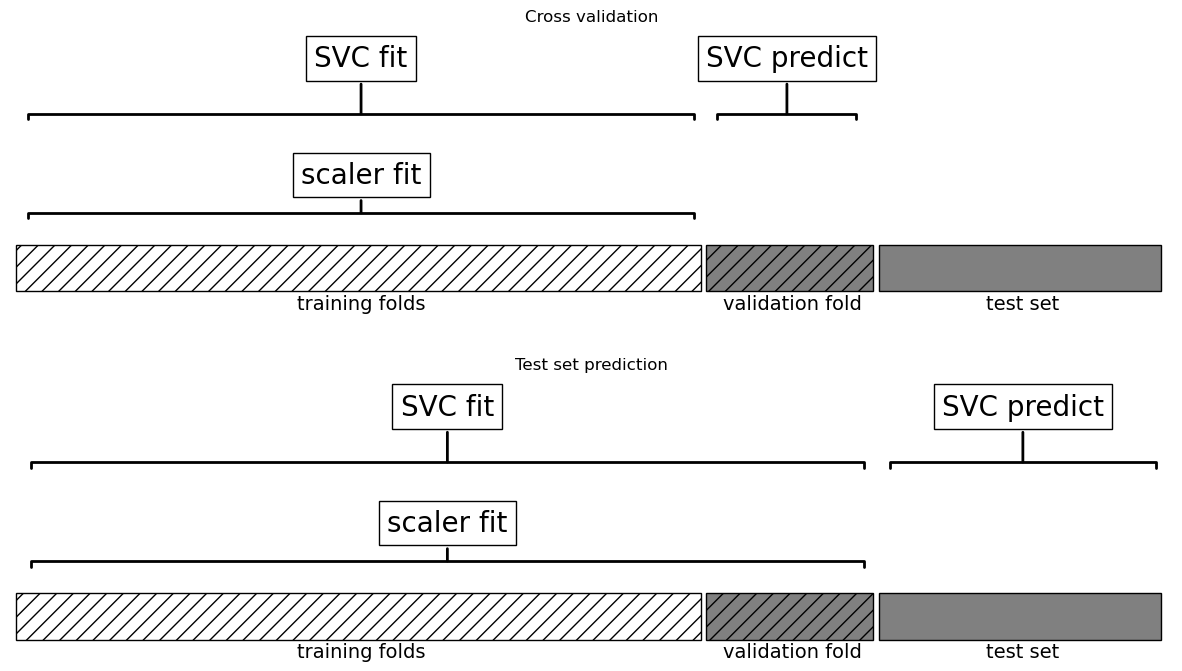

In [11]:
mglearn.plots.plot_proper_processing()

## Illustrating Information Leakage

In [12]:
rnd = np.random.RandomState(seed=22)
X = rnd.normal(size=(100,10000))
y = rnd.normal(size=(100,))

In [13]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression,percentile=5).fit(X,y)
X_selected = select.transform(X)
print('X_selected.shape', X_selected.shape)

X_selected.shape (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print('교차 검증 점수(리지): {:.2f}'.format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(리지): 0.92


In [15]:
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)), ('ridge', Ridge())])
print('교차 검증 점수(파이프라인): {:.2f}'.format(np.mean(cross_val_score(pipe,X,y,cv=5))))

교차 검증 점수(파이프라인): -0.04


# The General Pipeline Interface

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
        
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformd = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
        
    return self.steps[-1][1].predict(X_transformed)

In [18]:
from sklearn import set_config

set_config(display = 'diagram')
pipe

Pipeline(steps=[('select',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_regression at 0x0000014D41EC16C0>)),
                ('ridge', Ridge())])

In [19]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [20]:
print('파이프라인 단계:\n', pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2),StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [22]:
pipe.fit(cancer.data)

components = pipe.named_steps['pca'].components_
print('components.shape:', components.shape)

components.shape: (2, 30)


In [23]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [24]:
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=22)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [26]:
print('최상의 모델:\n', grid.best_estimator_)

최상의 모델:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [27]:
print('로지스틱 회귀 단계:\n', grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계:
 LogisticRegression(C=1, max_iter=1000)


In [28]:
print('로지스틱 회귀 계수:\n', grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수:
 [[-0.76581899 -0.74729764 -0.70561025 -0.71376968 -0.15237432  0.5103768
  -0.79327801 -0.89223924  0.20810081  0.64920546 -1.08217497  0.24287694
  -0.74738669 -0.88849508 -0.38989013  0.55802944 -0.08484353 -0.20032548
   0.4175941   0.62903793 -0.95739779 -1.0988187  -0.78864668 -0.90416901
  -1.22318032  0.11095833 -0.97813937 -0.76304809 -0.92087284 -0.27356867]]


# Grid-Searching Preprocessing Steps and Model Parameters

In [29]:
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
data = np.hstack([raw_df.values[::2,:], raw_df.values[1::2,:2]])
target = raw_df.values[1::2,2]
X_train, X_test, y_train, y_test =train_test_split(data, target, random_state=22)

from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(StandardScaler(),
                     PolynomialFeatures(),
                     Ridge())

In [30]:
param_grid = {'polynomialfeatures__degree':[1,2,3,4,5],
              'ridge__alpha': [.001, .01, .1, 1, 10, 100,1000]}

In [31]:
grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3, 4, 5],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

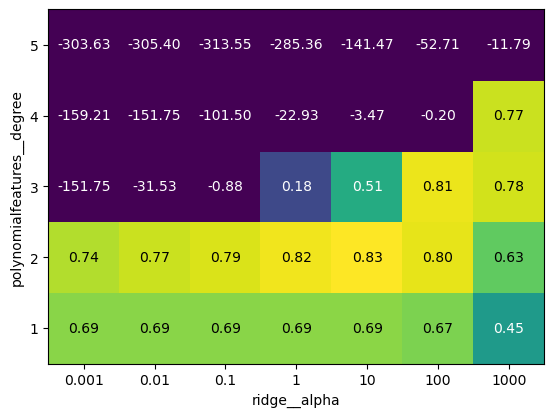

In [32]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(5, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)
plt.show()

In [33]:
print('최적의 매개변수:', grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print('테스트 세트 점수:{:.2f}'.format(grid.score(X_test,y_test)))

테스트 세트 점수:0.86


In [35]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.75


# Grid-Searching Which Model To Use

In [36]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [37]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
 {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
 'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'classifier': [RandomForestClassifier(n_estimators=100)],
 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=22)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))


Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.94


## Pipeline Cashing

In [39]:
# from tempfile import mkdtemp
# from shutil import rmtree
# cache_dir = mkdtemp()

# pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge(),
#                      memory=cache_dir)
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train)

# rmtree(cache_dir)